In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import fastai
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
from fastai.train import BnFreeze
import os
from radam import *
from csvlogger import *
from mish import *
import cv2
from albumentations import *
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

fastai.__version__

'1.0.61'

In [2]:
sz = 128
bs = 8
nfolds = 4
fold = 0
SEED = 43
N = 128
Nr = 96
#4 datasets for tiles produced with different padding
TRAIN = ['data/train_128x128x128','data/train1_128x128x128','data/train2_128x128x128','data/train3_128x128x128']
LABELS = 'data/train_d2.csv'
LABELS_D2 = 'data/d2.csv'
OUT = 'model0'
EXCLUDE = 'data/PANDA_Suspicious_Slides.csv'
NUM_WORKERS = 24

os.makedirs(OUT, exist_ok=True)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [ ]:
df = pd.read_csv(LABELS).set_index('image_id')
df = df.join(pd.read_csv(LABELS_D2).set_index('image_id'))
df.head()
files = sorted(set([p[:32] for p in os.listdir(TRAIN[0])]))
df.gleason_score = df.gleason_score.replace('negative','0+0')
df = df.loc[files]
df_e = df.loc[df.isup_grade != df.isup_grade0].copy().reset_index()
df = df.loc[df.isup_grade == df.isup_grade0]
df = df.reset_index()
splits = StratifiedKFold(n_splits=nfolds, random_state=SEED, shuffle=True)
splits = list(splits.split(df,df.isup_grade))
folds_splits = np.zeros(len(df)).astype(np.int)
for i in range(nfolds):
    folds_splits[splits[i][1]] = i
df['split'] = folds_splits
df = pd.concat((df,df_e)).fillna(-1)
df.split = df.split.astype(np.int)
Ng, Ns = df.nunique()[2], df.nunique()[3]
score_map = {s:i for i,s in enumerate(df.gleason_score.unique())}
df['score'] = df.gleason_score.map(score_map)
df['provider'] = df.data_provider == 'karolinska'
df = df.loc[(df.data_provider == 'karolinska') |
            ((df.data_provider == 'radboud') & (np.abs(df.isup_grade - df.isup_grade_d2 + 0.5) < 0.75))]
df = df.set_index('image_id')
exclude = set(pd.read_csv(EXCLUDE).image_id)
df = df.loc[~df.index.isin(exclude)]
df = df.reset_index()

df = pd.read_csv('data/train.csv').set_index('image_id').join(df.set_index('image_id')['split']).fillna(-1)
df.split = df.split.astype(np.int)
df = df.reset_index()
df['provider'] = df.data_provider == 'karolinska'
df.gleason_score = df.gleason_score.replace('negative','0+0')
df['score'] = df.gleason_score.map(score_map)
df['isup_grade0'] = df['isup_grade'] 
df.head()

In [5]:
mean = np.array([1.0-0.85506157, 1.0-0.7035249, 1.0-0.80203127])
std = np.array([0.40011922, 0.52504386, 0.42675745])

def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))

class PANDADataset(Dataset):
    def __init__(self, df, fold=fold, train=True, tfms=None):
        self.df = df.copy()
        self.df = self.df.loc[self.df.split != -1]
        self.df = self.df.loc[self.df.split != fold] if train else self.df.loc[self.df.split == fold]
        self.df = self.df.reset_index(drop=True)
        self.train = train
        self.tfms = tfms
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        labels = self.df.iloc[idx][['isup_grade','score','provider','isup_grade0']].astype(np.long).values
        provider = self.df.iloc[idx].data_provider
        
        idx = self.df.iloc[idx].image_id
        imgs,masks = [],[]
        rg = random.sample(list(np.arange(N)), Nr if self.train else N)
        for i in rg:
            path = TRAIN[np.random.randint(len(TRAIN))] if self.train else TRAIN[0]
            img = cv2.cvtColor(cv2.imread(os.path.join(path,idx+'_'+str(i)+'.png')), cv2.COLOR_BGR2RGB)
            img = 255 - img
            if self.tfms is not None:
                augmented = self.tfms(image=img)
                img = augmented['image']
            imgs.append(img)
        imgs = [img2tensor((img/255.0 - mean)/std,np.float32) for img in imgs]

        return torch.stack(imgs,0), labels

In [6]:
def get_aug(p=1.0):
    return Compose([
        HorizontalFlip(),
        VerticalFlip(),
        RandomRotate90(),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.3, rotate_limit=15, p=0.9, 
                         border_mode=cv2.BORDER_CONSTANT),
        #OneOf([#off in most cases
        #    MotionBlur(blur_limit=3, p=0.1),
        #    MedianBlur(blur_limit=3, p=0.1),
        #    Blur(blur_limit=3, p=0.1),
        #], p=0.2),
        #OneOf([#off in most cases
        #    OpticalDistortion(p=0.3),
        #    GridDistortion(p=.1),
        #    IAAPiecewiseAffine(p=0.3),
        #], p=0.3),
        OneOf([
            HueSaturationValue(10,15,10),
            CLAHE(clip_limit=2),
            RandomBrightnessContrast(),            
        ], p=0.3),
    ], p=p)

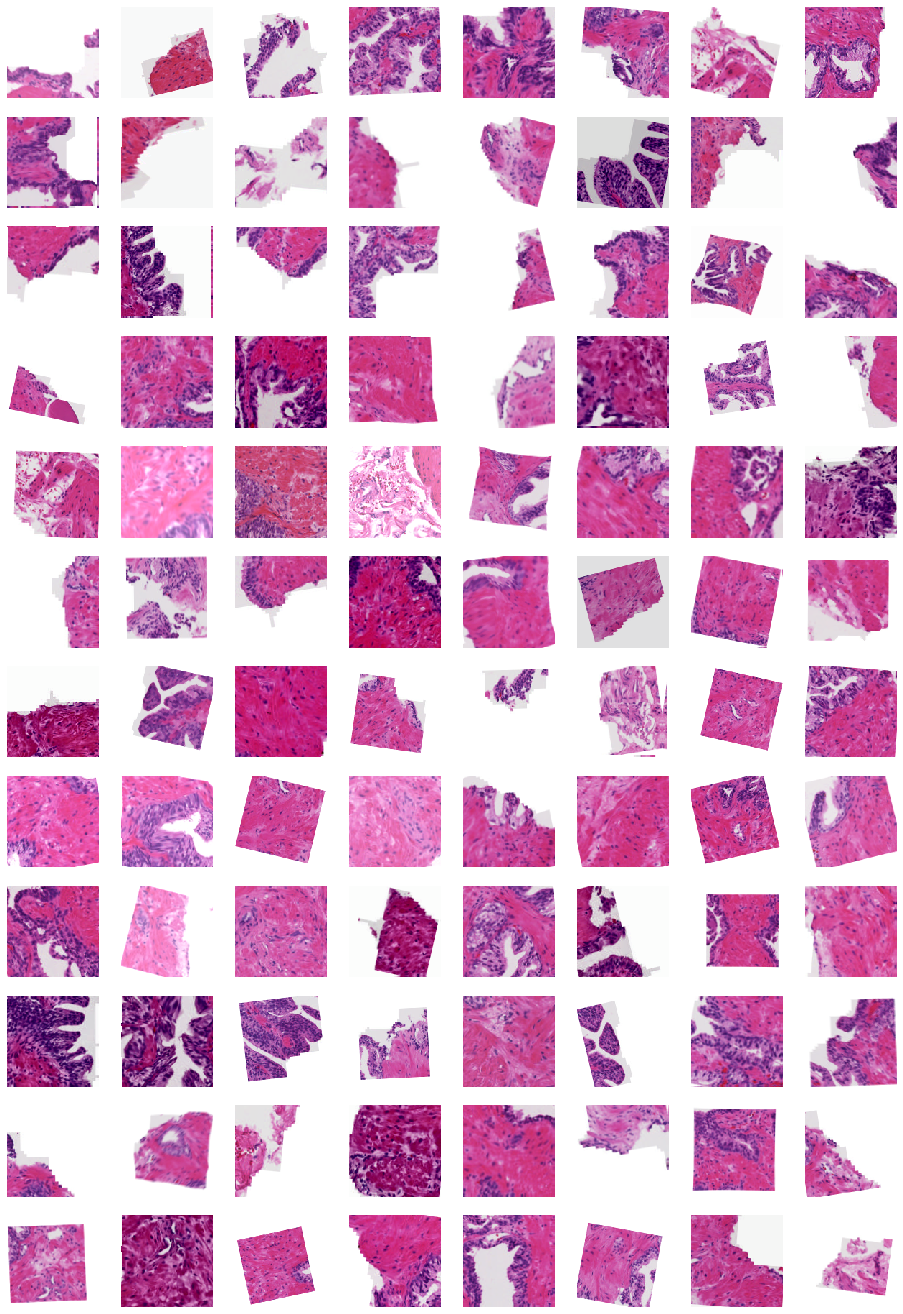

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

ds = PANDADataset(df, fold=fold, train=True, tfms=get_aug())
x,y = ds[5]
t = 255 - ((x.permute(0,2,3,1)*std + mean)*255.0).byte()
plt.figure(figsize=(16,32))
for i in range(len(t)):
    plt.subplot(16,8,i+1)
    plt.imshow(t[i])
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)

In [6]:
class Model(nn.Module):
    def __init__(self, arch='resnext50_32x4d_ssl', n=Ns, pre=True,ps=0.5):
        super().__init__()
        m = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', arch)
        nc = list(m.children())[-1].in_features
        self.enc = nn.Sequential(*list(m.children())[:-2])
        self.head = nn.Sequential(AdaptiveConcatPool2d(),Flatten(),
                                  nn.Linear(2*nc,512),Mish(),nn.GroupNorm(32,512),
        
    def forward(self, x):
        shape = x.shape
        n = shape[1]
        x = x.view(-1,shape[2],shape[3],shape[4])
        x = self.enc(x)
        
        shape = x.shape
        x = x.view(-1,n,shape[1],shape[2],shape[3]).permute(0,2,1,3,4).contiguous()\
          .view(-1,shape[1],shape[2]*n,shape[3])
        x = self.head(x)
        return x[:,:1],x[:,1:]

In [7]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

get_n_params(Model())

Using cache found in /home/iafoss/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


25082183

In [12]:
y_shift = df.isup_grade.mean()
def Kloss(x, target):
    x = Ng*torch.sigmoid(x.float()).view(-1) - 0.5
    target = target.float()
    y_shift = target.mean()
    return 1.0 - (2.0*((x-y_shift)*(target-y_shift)).sum() - 1e-3)/\
        (((x-y_shift)**2).sum() + ((target-y_shift)**2).sum() + 1e-3)

def Combine_loss(x, target):
    loss_c = Kloss(x[0].float(),target[:,0])
    loss_caux = F.cross_entropy(x[1].float(),target[:,1])
    return loss_c + 0.08*loss_caux

In [13]:
class DConfusionMatrix(Callback):
    def __init__(self, provider=None, **kwargs):
        self.provider=provider
        super().__init__(**kwargs)
    
    def on_train_begin(self, **kwargs):
        self.n_classes = 0

    def on_epoch_begin(self, **kwargs):
        self.cm = None

    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        if self.provider is None:
            last_output = last_output[0]
            last_target = last_target[:,0]
        else:
            idxs = last_target[:,2] == self.provider
            last_output = last_output[0][idxs]
            last_target = last_target[:,0][idxs]
            if len(last_output)  == 0: return
        preds = torch.clamp((Ng*torch.sigmoid(last_output.float())).long().view(-1).cpu(),0,5)
        targs = last_target.cpu()
        if self.n_classes == 0:
            self.n_classes = Ng
            self.x = torch.arange(0, self.n_classes)
        cm = ((preds==self.x[:, None]) & (targs==self.x[:, None, None])).sum(dim=2, dtype=torch.float32)
        if self.cm is None: self.cm =  cm
        else:               self.cm += cm

    def on_epoch_end(self, **kwargs):
        self.metric = self.cm

class DKappaScore(DConfusionMatrix):
    def __init__(self, weights:Optional[str]=None, **kwargs):
        super().__init__(**kwargs)
        self.weights = weights

    def on_epoch_end(self, last_metrics, **kwargs):
        sum0 = self.cm.sum(dim=0)
        sum1 = self.cm.sum(dim=1)
        expected = torch.einsum('i,j->ij', (sum0, sum1)) / sum0.sum()
        if self.weights is None:
            w = torch.ones((self.n_classes, self.n_classes))
            w[self.x, self.x] = 0
        elif self.weights == "linear" or self.weights == "quadratic":
            w = torch.zeros((self.n_classes, self.n_classes))
            w += torch.arange(self.n_classes, dtype=torch.float)
            w = torch.abs(w - torch.t(w)) if self.weights == "linear" else (w - torch.t(w)) ** 2
        else: raise ValueError('Unknown weights. Expected None, "linear", or "quadratic".')
        k = torch.sum(w * self.cm) / torch.sum(w * expected)
        return add_metrics(last_metrics, 1-k)
    
class kappa_k(DKappaScore):
    def __init__(self):
        super().__init__(weights='quadratic',provider=1)
        
class kappa_r(DKappaScore):
    def __init__(self):
        super().__init__(weights='quadratic',provider=0)

In [13]:
fname = 'RNXT50_128kr_8'
pred,pred_y = [],[]
for fold in range(nfolds):
    ds_t = PANDADataset(df, fold=fold, train=True, tfms=get_aug())
    ds_v = PANDADataset(df, fold=fold, train=False)
    data = DataBunch.create(ds_t,ds_v,bs=bs,num_workers=NUM_WORKERS)
    model = Model()
    model.load_state_dict(torch.load(os.path.join('d1',f'RNXT50_s43_{fold}.pth')))
    model = nn.DataParallel(model)
    learn = Learner(data, model, loss_func=Combine_loss, opt_func=Over9000, 
                metrics=[DKappaScore(weights='quadratic'),kappa_k(),kappa_r()]).to_fp16()
    logger = CSVLogger(learn,os.path.join(OUT,f'log_{fname}_{fold}'))
    learn.clip_grad = 1.0
    learn.split([model.module.head])
    learn.unfreeze()

    learn.fit_one_cycle(32, max_lr=slice(1e-4,1e-3), div_factor=50, pct_start=0.0, 
      callbacks = [SaveModelCallback(learn,name=f'model',monitor='d_kappa_score')])
    torch.save(learn.model.module.state_dict(),os.path.join(OUT,f'{fname}_{fold}.pth'))
    
    learn.model.eval()
    with torch.no_grad():
        for step, (x, y) in progress_bar(enumerate(data.dl(DatasetType.Valid)),
                                     total=len(data.dl(DatasetType.Valid))):
            p = learn.model(x.cuda().half())
            pred.append(p[0].float().view(-1).cpu())
            pred_y.append(y[:,0].cpu())
            
p = torch.clamp((6.0*torch.sigmoid(torch.cat(pred))).long(),0,5)
t = torch.cat(pred_y)
print(cohen_kappa_score(p,t,weights='quadratic'))
print(confusion_matrix(t,p))

Using cache found in /home/iafoss/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


epoch,train_loss,valid_loss,d_kappa_score,kappa_k,kappa_r,time
0,0.355020,0.286772,0.844942,0.784779,0.862722,07:47
1,0.313017,0.280139,0.837068,0.744564,0.885374,07:36
2,0.275751,0.209437,0.884532,0.813916,0.923827,07:29
3,0.256788,0.220915,0.884912,0.822784,0.928337,07:40
4,0.238732,0.188288,0.904940,0.864148,0.928485,07:50
5,0.237405,0.197771,0.892356,0.856312,0.910932,07:58
6,0.217124,0.171714,0.916930,0.870663,0.946342,08:04
7,0.244538,0.160965,0.920763,0.887949,0.937672,08:05
8,0.239856,0.141407,0.930488,0.898384,0.947894,08:07
9,0.202256,0.157172,0.921384,0.896131,0.931720,08:09


Better model found at epoch 0 with d_kappa_score value: 0.8449422717094421.
Better model found at epoch 2 with d_kappa_score value: 0.8845319747924805.
Better model found at epoch 3 with d_kappa_score value: 0.8849124908447266.
Better model found at epoch 4 with d_kappa_score value: 0.9049398899078369.
Better model found at epoch 6 with d_kappa_score value: 0.9169295430183411.
Better model found at epoch 7 with d_kappa_score value: 0.920763373374939.
Better model found at epoch 8 with d_kappa_score value: 0.9304875731468201.
Better model found at epoch 13 with d_kappa_score value: 0.9352754950523376.
Better model found at epoch 16 with d_kappa_score value: 0.9395422339439392.
Better model found at epoch 18 with d_kappa_score value: 0.9405519366264343.
Better model found at epoch 25 with d_kappa_score value: 0.9432386159896851.
Better model found at epoch 27 with d_kappa_score value: 0.9433774352073669.
Better model found at epoch 31 with d_kappa_score value: 0.943584144115448.


Using cache found in /home/iafoss/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


epoch,train_loss,valid_loss,d_kappa_score,kappa_k,kappa_r,time
0,0.318538,0.293154,0.838915,0.764751,0.859659,08:02
1,0.289712,0.236993,0.873183,0.809053,0.899238,08:00
2,0.264430,0.218449,0.884052,0.830350,0.901633,08:01
3,0.248968,0.307857,0.818027,0.783382,0.813668,08:04
4,0.251627,0.231863,0.869076,0.839575,0.866119,08:04
5,0.224647,0.196778,0.897130,0.857130,0.906485,08:05
6,0.235572,0.226087,0.871776,0.797218,0.919319,08:08
7,0.218610,0.268618,0.853043,0.793869,0.870420,08:06
8,0.210857,0.159082,0.918922,0.876534,0.936111,08:08
9,0.226900,0.175045,0.907391,0.847628,0.932139,08:07


Better model found at epoch 0 with d_kappa_score value: 0.8389149308204651.
Better model found at epoch 1 with d_kappa_score value: 0.8731825947761536.
Better model found at epoch 2 with d_kappa_score value: 0.8840517997741699.
Better model found at epoch 5 with d_kappa_score value: 0.8971298336982727.
Better model found at epoch 8 with d_kappa_score value: 0.9189220666885376.
Better model found at epoch 11 with d_kappa_score value: 0.9303625226020813.
Better model found at epoch 14 with d_kappa_score value: 0.9372523427009583.
Better model found at epoch 19 with d_kappa_score value: 0.9382885694503784.
Better model found at epoch 21 with d_kappa_score value: 0.9448394179344177.
Better model found at epoch 23 with d_kappa_score value: 0.9451946020126343.
Better model found at epoch 24 with d_kappa_score value: 0.947568416595459.
Better model found at epoch 25 with d_kappa_score value: 0.9489811658859253.
Better model found at epoch 27 with d_kappa_score value: 0.9492509961128235.


Using cache found in /home/iafoss/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


epoch,train_loss,valid_loss,d_kappa_score,kappa_k,kappa_r,time
0,0.371034,0.260356,0.866921,0.803092,0.897429,08:13
1,0.320136,0.234524,0.876063,0.835527,0.888746,08:11
2,0.259776,0.190265,0.908613,0.876882,0.919150,08:11
3,0.260692,0.168466,0.921712,0.879096,0.943003,08:11
4,0.231701,0.185925,0.906686,0.872289,0.924364,08:10
5,0.225961,0.182284,0.914173,0.878686,0.931702,08:10
6,0.226560,0.158687,0.926074,0.895574,0.940667,08:11
7,0.215512,0.148562,0.930440,0.905659,0.938201,08:10
8,0.196998,0.146690,0.928176,0.890618,0.946298,08:11
9,0.216918,0.152148,0.923799,0.885374,0.942986,08:10


Better model found at epoch 0 with d_kappa_score value: 0.8669213056564331.
Better model found at epoch 1 with d_kappa_score value: 0.876063346862793.
Better model found at epoch 2 with d_kappa_score value: 0.9086132049560547.
Better model found at epoch 3 with d_kappa_score value: 0.9217117428779602.
Better model found at epoch 6 with d_kappa_score value: 0.9260737895965576.
Better model found at epoch 7 with d_kappa_score value: 0.9304395914077759.
Better model found at epoch 13 with d_kappa_score value: 0.9376002550125122.
Better model found at epoch 15 with d_kappa_score value: 0.9383760094642639.
Better model found at epoch 16 with d_kappa_score value: 0.9406371712684631.
Better model found at epoch 17 with d_kappa_score value: 0.9429503083229065.
Better model found at epoch 18 with d_kappa_score value: 0.9433194994926453.
Better model found at epoch 20 with d_kappa_score value: 0.9452605247497559.
Better model found at epoch 21 with d_kappa_score value: 0.9482449889183044.
Better

Using cache found in /home/iafoss/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


epoch,train_loss,valid_loss,d_kappa_score,kappa_k,kappa_r,time
0,0.366239,0.239211,0.882619,0.829142,0.902354,08:13
1,0.265921,0.257364,0.869219,0.784355,0.910150,08:09
2,0.279444,0.196478,0.900824,0.847875,0.922724,08:10
3,0.302763,0.180453,0.913333,0.875656,0.929572,08:10
4,0.229613,0.194998,0.898854,0.863524,0.909126,08:10
5,0.241603,0.203343,0.890527,0.836513,0.913376,08:11
6,0.195263,0.176141,0.905141,0.898073,0.887667,08:09
7,0.229629,0.168335,0.912092,0.864775,0.933624,08:09
8,0.204727,0.150556,0.925208,0.899336,0.933523,08:09
9,0.201128,0.147717,0.926083,0.894298,0.939336,08:09


Better model found at epoch 0 with d_kappa_score value: 0.8826189637184143.
Better model found at epoch 2 with d_kappa_score value: 0.900824248790741.
Better model found at epoch 3 with d_kappa_score value: 0.9133331179618835.
Better model found at epoch 8 with d_kappa_score value: 0.9252076745033264.
Better model found at epoch 9 with d_kappa_score value: 0.9260826110839844.
Better model found at epoch 11 with d_kappa_score value: 0.9326913356781006.
Better model found at epoch 13 with d_kappa_score value: 0.9333337545394897.
Better model found at epoch 15 with d_kappa_score value: 0.9371500611305237.
Better model found at epoch 17 with d_kappa_score value: 0.9390252828598022.
Better model found at epoch 22 with d_kappa_score value: 0.9468173384666443.
Better model found at epoch 26 with d_kappa_score value: 0.9471642971038818.


0.9479778400585391
[[2416  270   35    6    2    0]
 [  83 1967  262   16    0    1]
 [   9  256  589  195   12    0]
 [   3   13   90  518  175    6]
 [   0    2   23  162  586  155]
 [   0    1    0   19  185  643]]
